In [3]:
%matplotlib inline


# Cross Subject SSVEP



In [4]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import scipy
from pyriemann.estimation import Covariances as COVs
from estimation import Covariances, mean, scm
from classifiers import MDM, TangentSpace

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

import moabb
from moabb.datasets import SSVEPExo
from moabb.evaluations import CrossSubjectEvaluation,CrossSessionEvaluation,WithinSessionEvaluation
from moabb.paradigms import SSVEP, FilterBankSSVEP
from moabb.pipelines import SSVEP_CCA, ExtendedSSVEPSignal


warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
moabb.set_log_level("info")

In [5]:
def huber_prime(x,r):
    if x < r:
        return 1
    else:
        return 0


In [6]:
def split(signal):
    n_sessions = signal.shape[0]//32
    trains_idx,tests_idx = [],[]
    for i in range(n_sessions):
        test_idx = list(range(i*32,(i+1)*32))
        train_idx=[]
        for j in range(signal.shape[0]):
            if not (j in test_idx):
                train_idx.append(j)
        trains_idx.append(train_idx)
        tests_idx.append(test_idx)
    return trains_idx,tests_idx


In [7]:
def splitbis(signal):
    n_sessions = signal.shape[0]//32
    trains_idx,tests_idx = [list(range(0,32*(n_sessions-1)))],[list(range(32*(n_sessions-1),32*n_sessions))]
    return trains_idx,tests_idx

## Loading dataset



In [8]:
dataset = SSVEPExo()
#dataset.interval = [2,5]
interval = dataset.interval
#dataset.subject_list = dataset.subject_list[:1]

In [9]:
print(dataset.subject_list)
print(interval)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[2, 4]


In [10]:
records = dataset.get_data()

## Choose paradigm




In [11]:
paradigm_fb = FilterBankSSVEP(filters=None, n_classes=4,resample = 128)

2021-09-01 10:32:15,076 WARNING MainThread moabb.paradigms.ssvep Choosing the first 4 classes from all possible events


In [12]:
paradigm_fb.tmin

0.0

In [13]:
print(paradigm_fb.tmax)

None


Classes are defined by the frequency of the stimulation, here we use
the first two frequencies of the dataset, 13 and 17 Hz.
The evaluation function uses a LabelEncoder, transforming them
to 0 and 1



In [14]:
freqs = paradigm_fb.used_events(dataset)
freqs

{'13': 2, '17': 3, '21': 4, 'rest': 1}

## Create pipelines



In [24]:
pipeline = {}

pipeline["MDM + scm covs"] = make_pipeline(
    ExtendedSSVEPSignal(),
    COVs(estimator="scm"),
    MDM()
)

pipeline["MDM + lwf covs"] = make_pipeline(
    ExtendedSSVEPSignal(),
    COVs(estimator="lwf"),
    MDM()
)

pipeline["MDM + student covs"] = make_pipeline(
    ExtendedSSVEPSignal(),
    Covariances(estimator="student"),
    MDM()
)

In [ ]:
pipeline["MDM + huber adapt covs"] = make_pipeline(
    ExtendedSSVEPSignal(),
    Covariances(estimator="huber adaptive"),
    MDM()
)

pipeline["MDM + huber non adapt covs"] = make_pipeline(
    ExtendedSSVEPSignal(),
    Covariances(estimator="huber non adaptive"),
    MDM()
)

pipeline["MDM + tyler adapt covs"] = make_pipeline(
    ExtendedSSVEPSignal(),
    Covariances(estimator="tyler adaptive"),
    MDM()
)

pipeline["MDM + tyler non adapt covs"] = make_pipeline(
    ExtendedSSVEPSignal(),
    Covariances(estimator="tyler non normalized non adaptive"),
    MDM()
)





In [16]:
X, y, metadata = paradigm_fb.get_data(dataset)

In [17]:
X.shape

(960, 8, 256, 3)

In [18]:
dictio={"rest":0,"13":1,"21":2,"17":3}
import numpy as np
y_= [dictio[y[l]] for l in range(len(y))]
y =np.asarray(y_)

In [19]:
signals = []
labels=[]
n_sessions=[]
n = 0
for subject in dataset.subject_list :
    n_session = len(records[subject]['session_0'])
    n_sessions.append(n_session)
    m =32*n_session +n
    signals.append(X[n:m])
    labels.append(y[n:m])
    n=m

## Evaluation

The evaluation will return a dataframe containing a single AUC score for
each subject / session of the dataset, and for each pipeline.

Results are saved into the database, so that if you add a new pipeline, it
will not run again the evaluation unless a parameter has changed. Results can
be overwritten if necessary.



In [ ]:
results = {"subject":[],"score":[],"train samples":[], "test samples":[], "pipeline":[]}
for k in pipeline.keys():
    clf= pipeline[k]
    print(clf)
    for i in tqdm(range(len(dataset.subject_list))):
        accs= []
        subject = dataset.subject_list[i]
        signal,n_session,label = signals[i],n_sessions[i],labels[i]
        trains_idx,tests_idx = split(signal)
        for train_idx,test_idx in zip(trains_idx,tests_idx):
            X_train,X_test = signal[train_idx],signal[test_idx]
            y_train,y_test = label[train_idx],label[test_idx]
            clf.fit(X_train,y_train)
            preds= clf.predict(X_test)
            acc = np.mean(preds==y_test)
            accs.append(acc)
        results["subject"].append(subject)
        results["score"].append(np.mean(accs))
        results["pipeline"].append(k)
        results["train samples"].append(len(train_idx))
        results["test samples"].append(len(test_idx))

  0%|          | 0/12 [00:00<?, ?it/s]

Pipeline(steps=[('extendedssvepsignal', ExtendedSSVEPSignal()),
                ('covariances', Covariances()), ('mdm', MDM())])


  0%|          | 0/12 [00:00<?, ?it/s]

Pipeline(steps=[('extendedssvepsignal', ExtendedSSVEPSignal()),
                ('covariances', Covariances(estimator='lwf')), ('mdm', MDM())])


  0%|          | 0/12 [00:00<?, ?it/s]

Pipeline(steps=[('extendedssvepsignal', ExtendedSSVEPSignal()),
                ('covariances', Covariances(estimator='student')),
                ('mdm', MDM())])


 58%|█████▊    | 7/12 [32:45<30:28, 365.67s/it]

Filter bank processing, determine automatically the filter from the
stimulation frequency values of events.



## Plot Results

Here we plot the results.



In [21]:
df = pd.DataFrame(results)
df

,subject,score,train samples,test samples,pipeline
0,1,0.437500,32,32,MDM + scm covs
1,2,0.578125,32,32,MDM + scm covs
2,3,0.843750,32,32,MDM + scm covs
3,4,0.625000,32,32,MDM + scm covs
4,5,0.484375,32,32,MDM + scm covs
5,6,0.609375,32,32,MDM + scm covs
6,7,0.645833,64,32,MDM + scm covs
7,8,0.640625,32,32,MDM + scm covs
8,9,0.375000,32,32,MDM + scm covs
9,10,0.468750,96,32,MDM + scm covs


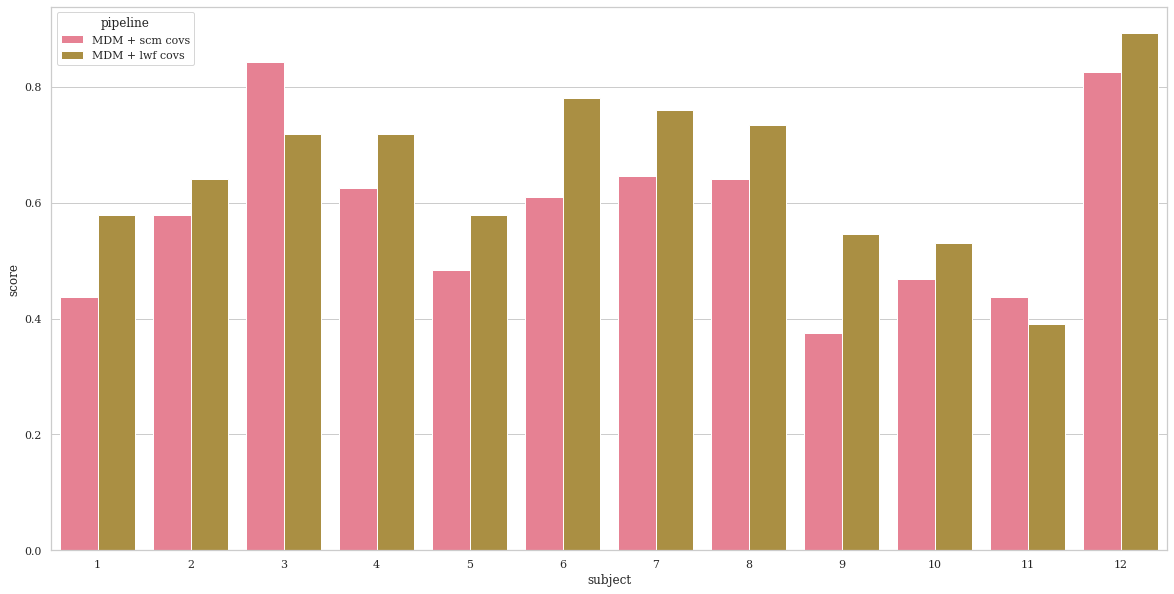

In [22]:
plt.figure(figsize=(20,10))
sns.barplot(data=df, y="score", x="subject", hue="pipeline")

plt.show()

In [23]:
for m in range(len(list(pipeline.keys()))):
    mean_  = 0
    for i in range(12):
        mean_ += df.loc[i+12*m].at['score']
    print(df.loc[12*m].at['pipeline'], "=",mean_/12)

MDM + scm covs = 0.5809027777777778
MDM + lwf covs = 0.6560763888888889


## Cross session evaluation

In [ ]:
#cross_session

evaluation1 = WithinSessionEvaluation(
    paradigm=paradigm_fb, datasets=dataset, overwrite=False
)
results1 = evaluation1.process(pipeline)

results1

In [ ]:
plt.figure(figsize=(20,10))
sns.barplot(data=results1, y="score", x="subject", hue="pipeline")

plt.show()

In [ ]:
df1 = pd.DataFrame(results1)
df1

In [ ]:
for m in range(len(list(pipeline.keys()))):
    mean_  = 0
    for i in range(12):
        mean_ += df1.loc[i+12*m].at['score']
    print(df1.loc[12*m].at['pipeline'], "=",mean_/12)